![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

## Punto 1

Como podemos observar para caso de la variable predictora **'season'** se tiene un comportamiento que para el caso de la categoría 1 invierno se tiene el menor número de alquileres en promedio de bicicletas y en caso opuesto para el caso de la categoría 3 verano se tiene el mayor caso de alquileres en promedio. Esto podría ser un indicador de que las condiciones climáticas son determinantes a la hora de determinar el número de alquileres. 

Por otro lado las variable **'hour'**, presenta un comportamiento que se puede relacionar con el comportamiento humano, ya que para horas altas de la noche y de madrugada, el promedio de alquileres es bajo, donde alcanza el mínimo a las 4:00 am, mientras que en las horas en que las personas tienen mayor movilidad por el trabajo se presenta su máximo locales a las 8:00 am y a las 5:00 pm.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

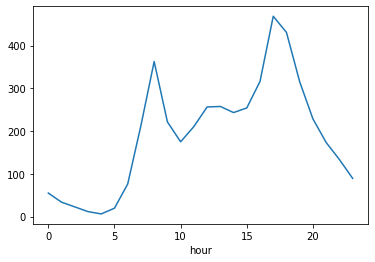

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

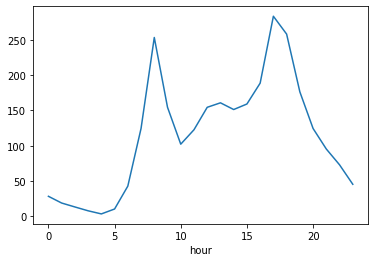

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes["season"] == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

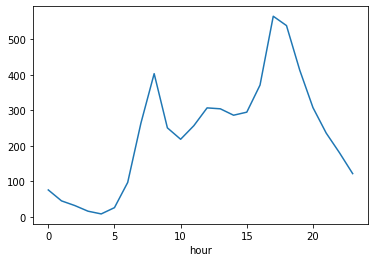

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes["season"] == 3].groupby('hour').total.mean().plot()

Lo primero que podemos observar es que en ambas graficas se tiene una relación muy similar entre el promedio de alquileres y la hora, con la diferencia que la cantidad de alquileres disminuye globalmente para invierno y aumenta para verano. 

Otro punto interesante, es que semejanza entre relaciones nos habla de una relación no lineal entre estas variables, ya que se logran unos máximos y mínimos durante el trascurso del día, lo que nos indica que una relación lineal no es lo mejor para tratar esta relación.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3

from sklearn.linear_model import LinearRegression

X = bikes[["season", "hour"]]
X["season"] = X["season"].astype(str)
y = bikes["total"]
X = pd.get_dummies(X, drop_first=True)


reg = LinearRegression().fit(X, y)

print(dict(zip(X.columns, reg.coef_)))

{'hour': 10.545206094069886, 'season_2': 100.31723191606602, 'season_3': 119.46754994593182, 'season_4': 84.08311787296776}


Como esperábamos los coeficientes relacionados con la estación del año aumentan de acuerdo lo hablado anteriormente, es mayor para verano y menor para invierno, y por cada hora que aumenta se aumenta en 10 el número de alquileres. El coeficiente asociado a la hora es el que presenta mayor limitación, ya que no es capaz de explicar los máximos y mínimos locales que observamos anteriormente, asume que a medida que crece la hora también lo hace el número de alquileres. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [10]:
# Celda 4

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain=0.001

tree_grow(X, y, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)


{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 382.8088308604629,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': [0, 1.0],
     'n_samples': 909,
     'gain': 226.40681148168596,
     'sl': {'y_pred': 1,
      'y_prob': 54.89934354485777,
      'level': 5,
      'split': [2, 1.0],
      'n_samples': 455,
      'gain': 282.0028542038244,
      'sl': {'y_pred': 1,
       'y_prob': 47.994169096209916,
       'level': 6,
       'split': -1,
       'n_samples': 341,


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

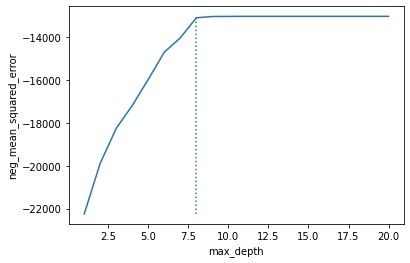

max_depth: 8
MSE Tree 13249.286428841735
MSE Reg 26125.777378491035


In [11]:
# Celda 5

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('neg_mean_squared_error')
plt.vlines(8, min(accuracy_scores), max(accuracy_scores), linestyles ="dotted")
plt.show()

print('max_depth:', 8) 

clf = DecisionTreeRegressor(max_depth=8, random_state=1)
clf.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

tree_MSE = mean_squared_error(y_test, clf.predict(X_test))
print('MSE Tree', tree_MSE)


reg = LinearRegression().fit(X_train, y_train)

reg_MSE = mean_squared_error(y_test, reg.predict(X_test))
print('MSE Reg', reg_MSE)



Para este ejercicio se hizo una partición del 30% de los datos para test y se compraron los modelos por medio el error cuadrático medio, donde se observó que para el caso del árbol de clasificación se obtuvo un mejor desempeño, con un error cuadratico médio de la mitad de la regresión, con una profundidad máxima de 8 para un mejor desempeño, y se superaron las limitaciones anteriormente mencionadas para la regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [12]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [13]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [14]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

max_depth: 4


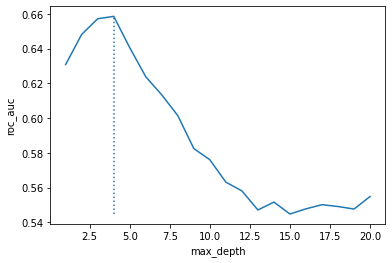

Tree Accuracy 0.6513333333333333
Tree f1_score 0.6345213137665969
LogisticRegression Accuracy 0.6146666666666667
LogisticRegression f1_score 0.6115591397849462


In [15]:
# Celda 6


# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc').mean())

print('max_depth:', accuracy_scores.index(max(accuracy_scores)) + 1)    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.vlines(accuracy_scores.index(max(accuracy_scores)) + 1, min(accuracy_scores), max(accuracy_scores), linestyles ="dotted")
plt.show()

clf = DecisionTreeClassifier(max_depth=accuracy_scores.index(max(accuracy_scores)) + 1, random_state=1)
clf.fit(X_train, y_train)


from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(random_state=0).fit(X_train, y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print('Tree Accuracy', accuracy_score(y_test, clf.predict(X_test)))

print('Tree f1_score', f1_score(y_test, clf.predict(X_test)))

print('LogisticRegression Accuracy', accuracy_score(y_test, reg.predict(X_test)))

print('LogisticRegression f1_score', f1_score(y_test, reg.predict(X_test)))




Se observa un mejor desempeño para el árbol de clasificación con una profundidad de 4.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [22]:
# Celda 7
from sklearn.ensemble import BaggingClassifier

clf_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth = 32), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_1.fit(X_train, y_train)

clf_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=4), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_2.fit(X_train, y_train)

clf_3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_3.fit(X_train, y_train)


# Creación de 100 muestras de bootstrap
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras boostrap

from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    if i < 100:
        trees[i] = DecisionTreeClassifier(max_depth=32, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
    elif i < 200:
        trees[i] = DecisionTreeClassifier(min_samples_leaf=4, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    else:
        trees[i] = LogisticRegression(random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
        
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)
    
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

print('DecisionTree max_depth Accuracy', accuracy_score(y_test, clf_1.predict(X_test)))
print('DecisionTree max_depth F1_score', f1_score(y_test, clf_1.predict(X_test)))


print('DecisionTree min_samples_leaf Accuracy', accuracy_score(y_test, clf_2.predict(X_test)))
print('DecisionTree min_samples_leaf F1_score', f1_score(y_test, clf_2.predict(X_test)))


print('LogisticRegression Accuracy', accuracy_score(y_test, clf_3.predict(X_test)))
print('LogisticRegression F1_score', f1_score(y_test, clf_3.predict(X_test)))

print('BaggingClassifier Accuracy', accuracy_score(y_test, y_pred))
print('BaggingClassifier F1_score', f1_score(y_test, y_pred))

DecisionTree max_depth Accuracy 0.64
DecisionTree max_depth F1_score 0.642384105960265
DecisionTree min_samples_leaf Accuracy 0.6546666666666666
DecisionTree min_samples_leaf F1_score 0.6564986737400531
LogisticRegression Accuracy 0.6173333333333333
LogisticRegression F1_score 0.6126855600539811
BaggingClassifier Accuracy 0.6253333333333333
BaggingClassifier F1_score 0.619241192411924


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [20]:
# Celda 8

samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

print('clf Accuracy', accuracy_score(y_test, y_pred))
print('clf f1_score', f1_score(y_test, y_pred))

clf Accuracy 0.6253333333333333
clf f1_score 0.619241192411924


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

**Celda 9**

Lo primero que podemos notar de este ejercicio es que el método de bagging con los 300 casos no presentó mejor desempeño, como si lo hizo los modelos con árboles, esto es principalmente a que está compuesto por una tercera parte de modelos lineales con desempeño bajo, lo que hace que este valor baje. Debido a esto se espera una mejora al ponderar los resultados, ya que no lo estaría dando una importancia menor a las regresiones logísticas. 

Esto anterior lo podríamos verificar al quitar las regresiones logísticas y ver los resultados.

Lo primero que podemos notar de este ejercicio es que el método de bagging con los 300 casos no presentó mejor desempeño, como si lo hizo los modelos con árboles, esto es principalmente a que está compuesto por una tercera parte de modelos lineales con desempeño bajo, lo que hace que este valor baje. Debido a esto se espera una mejora al ponderar los resultados, ya que no lo estaría dando una importancia menor a las regresiones logísticas. Esto anterior lo podríamos verificar al quitar las regresiones logísticas y comparar los resultados, como se observa a continuación ahí se obbserva una mejora:

In [24]:
# Celda 9


# Creación de 100 muestras de bootstrap
n_estimators = 200
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras boostrap

from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    if i < 100:
        trees[i] = DecisionTreeClassifier(max_depth=32, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
    else:
        trees[i] = DecisionTreeClassifier(min_samples_leaf=4, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
        
# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)
    
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

print('BaggingClassifier Accuracy', accuracy_score(y_test, y_pred))
print('BaggingClassifier F1_score', f1_score(y_test, y_pred))



samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
    
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)

# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

print('BaggingClassifier Ponderada Accuracy', accuracy_score(y_test, y_pred))
print('BaggingClassifier Ponderada f1_score', f1_score(y_test, y_pred))

BaggingClassifier Accuracy 0.652
BaggingClassifier F1_score 0.6506024096385543
BaggingClassifier Ponderada Accuracy 0.652
BaggingClassifier Ponderada f1_score 0.6491935483870968
